King County Real Estate '14-'15 Analysis 

Authors: Andrew Marinelli, Drew Bernklau, and Andy Schmeck ("The Andrew's Three)

# Overview

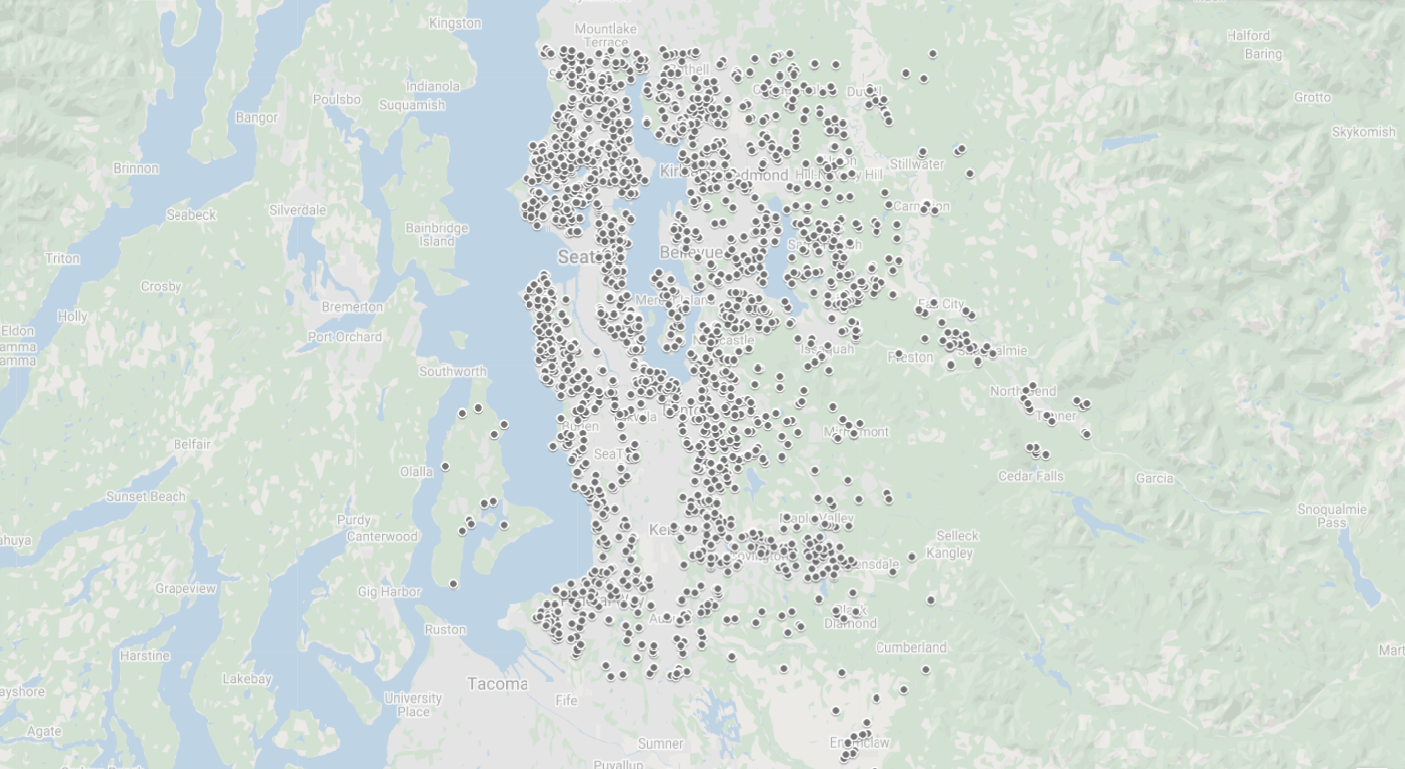

In [1]:
from PIL import Image
image = Image.open("King_County_homes_map.png")
image

This project analyzes data for Real Estate Company, dealing with hundreds of clients all over the Puget Sound area.  Descriptive analysis of the housing data, from King County, Washington between May 2014 to May 2015, show that homes vary in sale price due to many factors. Real Estate Company can use this anaysis to modify client interactions and offer more targeted advice in listing and selling their home. 

# Business Problem

One of the most frequently asked questions of realtors is "How should I prepare my house before selling it?" (RentSpree). Real Estate Company may be able to improve client relations and increase profits with a few targeted recommendations provided to the homeowners about which home renovations and improvements might increase the estimated value of their homes, increasing income for homeowner and realator.

# Data

The dataset is of King County 21,597 home sales between May 2014 through May 2015. Every home has a unique id; 92 homes were sold twice within the year. With price as the target variable, features that influenced a homeowner's selling price were kept: id, bedrooms, bathrooms, condition, price. 

In [2]:
import pandas as pd
df = pd.read_csv('data/kc_house_data.csv')

#### Train-Test-Split

The data was split 75%/25% 

In [5]:
y=df['price']
X=df.drop(columns='price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, /
                                                    train_size=0.75)

#### Excluding

Some features were excluded due to multicollinearity sqft_living, sqft_living15, sqft_above, and sqft_basement. We chose to keep bathrooms as the most specific of the group. 

In [25]:
new_df= X_train[['sqft_living', 'sqft_living15', 'sqft_above', /
                 'sqft_basement', 'bathrooms']]
corr = new_df.corr()
fig, ax = plt.subplots()
ax = sns.heatmap(data=corr, annot=True)
ax.set_title("Multicollinearity of Features");


SyntaxError: invalid syntax (<ipython-input-25-9fffb9edbf4a>, line 1)

Many features were excluded because of our business problem. If the homeowner was not able to make the changes to their own house, the features were excluded. This included floors, yr_built, grade, view, waterfront, date, zipcode, yr_renovated, lat, long, sqft_lot, sqft_living15, and sqft_lot15. As an example, the advice, "move your house to the waterfront," would not be helpful to a homeowner who does not live on the waterfront. 

In [4]:
X_train.drop(columns=['sqft_living', 'floors', 'yr_built', 'grade', /
                      'view', 'waterfront', 'date', 'zipcode', /
                      'yr_renovated', 'lat', 'long', 'sqft_lot', /
                      'sqft_living15', 'sqft_lot15', 'sqft_above', /
                      'sqft_basement'], inplace=True)

,id,price,bedrooms,bathrooms,condition
0,7129300520,221900.0,3,1.00,Average
1,6414100192,538000.0,3,2.25,Average
2,5631500400,180000.0,2,1.00,Average
3,2487200875,604000.0,4,3.00,Very Good
4,1954400510,510000.0,3,2.00,Average


# Methods

Some outliers in price, greater than 3 standard deviations from the mean, were removed.

In [6]:
#combine training data
df_train = pd.concat([X_train,y_train], axis=1)
# slice away homes with a price greater than 3 standard devations from the mean
std_three = y_train.std()*3
threshold = y_train.mean() + std_three
print(threshold)
df_train = df_train[df_train['price'] <= threshold]
X_train = df_train.drop(columns='price', axis=1) 
y_train = df_train['price']

1640318.711439713


#### One Hot Encoder "Condition"

To change the condition of the home into discrete variables, OneHotEncoder was applied to the training data.

In [7]:
#fit and transform the initiated OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
X_train_condition = X_train[['condition']]
X_train_fittransform = ohe.fit_transform(X_train_condition)
ohe.categories_[0]
#create a new dataframe
condition_df = pd.DataFrame(X_train_fittransform, columns=ohe.categories_[0], /
                            index=X_train.index)
#drop the old column
X_train.drop(columns='condition', inplace=True)
#add the new ones
X_train = pd.concat([X_train, condition_df], axis=1)
#strip white space from very good
X_train.columns = X_train.columns.str.replace(" ", "")
X_train.columns

Index(['id', 'bedrooms', 'bathrooms', 'Average', 'Fair', 'Good', 'Poor',
       'VeryGood'],
      dtype='object')

#### Test set cleaning

Do the same above to the test set before modeling

In [8]:
#drop columns
X_test.drop(columns=['sqft_living', 'floors', 'yr_built', 'grade', 'view',/
                     'waterfront', 'date', 'zipcode', 'yr_renovated', 'lat',/
                     'long', 'sqft_lot', 'sqft_living15', 'sqft_lot15', /
                     'sqft_above', 'sqft_basement'], inplace=True)
#combine test X and y
df_test = pd.concat([X_test,y_test], axis=1)
#shed outliers
std_three = y_test.std()*3
threshold = y_test.mean() + std_three
print(threshold)
df_test = df_test[df_test['price'] <= threshold]
X_test = df_test.drop(columns='price', axis=1) 
y_test = df_test['price']
#OHE Condition
X_test_condition = X_test[['condition']]
X_test_transform = ohe.transform(X_test_condition)
ohe.categories_[0]
condition_df = pd.DataFrame(X_test_transform, columns=ohe.categories_[0], index=X_test.index)
X_test.drop(columns='condition', inplace=True)
X_test = pd.concat([X_test, condition_df], axis=1)
# change Very Good to VeryGood
X_test.columns = X_test.columns.str.replace(" ", "")


1648650.7409405692


# Modeling

#### Baseline

In [11]:
#Dummy Regressor
X_baseline_train = X_train['id']
y_baseline_train = y_train
dr = DummyRegressor(strategy='mean')
baseline_model = dr.fit(X_baseline_train, y_baseline_train)
baseline_model.score(X_baseline_train, y_baseline_train)

0.0

In [12]:
#Baseline RMSE
y_hat_baseline_train = dr.predict(X_baseline_train)
rmse = []
rmse.append(np.sqrt(mean_squared_error(y_baseline_train, y_hat_baseline_train)))
print(rmse)

[1.0]


In [13]:
#Baseline Validation and RMSE
X_baseline_test = X_test['id']
y_baseline_test = y_test
test_score = dr.score(X_baseline_test,y_baseline_test)
print(test_score)
y_hat_baseline_test = dr.predict(X_baseline_test)
rmse = []
rmse.append(np.sqrt(mean_squared_error(y_baseline_test, y_hat_baseline_test)))
print(rmse)

[0.9999999999999999]


#### Simple Linear Regression

In [14]:
#OLS with price and bathrooms
df_train = pd.concat([X_train, y_train], axis=1)
f= 'price~bathrooms'
bathrooms_model = ols(formula=f, data=df_train).fit()
bathrooms_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     5183.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:08:32   Log-Likelihood:                -20305.
No. Observations:               15891   AIC:                         4.061e+04
Df Residuals:                   15889   BIC:                         4.063e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.855e-18      0.007   -8.5e-16      1.000      -0.014       0.014
bathrooms      0.4959      0.007     71.992      0.000       0.482       0.509
==============================================================================
Omnibus:                     3145.629   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6592.631
Skew:                           1.167   Prob(JB):                         0.00
Kurtosis:                       5.124   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#1st Model RMSE
X_bathrooms_train = X_train[['bathrooms']]
y_hat_bathrooms_train = bathrooms_model.predict(X_bathrooms_train)
rmse = []
rmse.append(np.sqrt(mean_squared_error(y_train, y_hat_bathrooms_train)))
print(rmse)

[0.8683556103743203]


In [16]:
#1st Model Validation and RMSE
X_bathrooms_test = X_test[['bathrooms']]
y_hat_bathrooms_test = bathrooms_model.predict(X_bathrooms_test)
rmse = []
rmse.append(np.sqrt(mean_squared_error(y_test, y_hat_bathrooms_test)))
print(rmse)

[0.868925644187992]


<ipython-input-17-2b879c1e1cd5>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


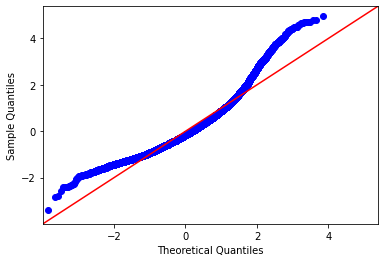

In [17]:
#Check Normality of Residuals
bathrooms_residuals= bathrooms_model.resid 
fig=sm.graphics.qqplot(bathrooms_residuals, dist=stats.norm, line='45', fit=True)
fig.show()

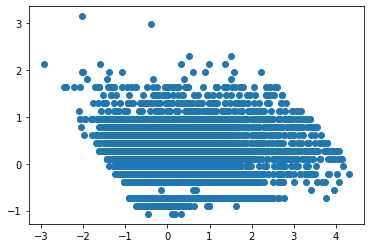

In [18]:
#Check Homoscedasticity of Residuals
plt.scatter(bathrooms_residuals, y_hat_bathrooms_train)

#### Mulitiple Linear Regression

In [19]:
#Stepwise Function

In [20]:
#Multiple OLS with Stepwise Results
df_train = pd.concat([X_train, y_train], axis=1)
f= 'price~bathrooms+bedrooms+VeryGood+Good+Average'
MLR_model = ols(formula=f, data=df_train).fit()
MLR_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     1124.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:08:34   Log-Likelihood:                -20141.
No. Observations:               15891   AIC:                         4.029e+04
Df Residuals:                   15885   BIC:                         4.034e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.453e-17      0.007   2.13e-15      1.000      -0.013       0.013
bathrooms      0.4715      0.008     57.537      0.000       0.455       0.488
bedrooms       0.0712      0.008      8.882      0.000       0.056       0.087
VeryGood       0.1438      0.020      7.107      0.000       0.104       0.183
Good           0.1495      0.032      4.687      0.000       0.087       0.212
Average        0.0948      0.034      2.761      0.006       0.027       0.162
==============================================================================
Omnibus:                     3077.805   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6431.936
Skew:                           1.144   Prob(JB):                         0.00
Kurtosis:                       5.116   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
#Multiple OLS RMSE
X_bbvgga_train = X_train[['bathrooms', 'bedrooms', 'VeryGood', 'Good', 'Average']]
y_hat_MLR_train = MLR_model.predict(X_bbvgga_train)
rmse = []
rmse.append(np.sqrt(mean_squared_error(y_train, y_hat_MLR_train)))
print(rmse)

[0.8594365426150726]


In [22]:
#Multiple OLS Validation and RMSE
df_test = pd.concat([X_test, y_test], axis=1)
X_bbvgga_test = X_test[['bathrooms', 'bedrooms', 'VeryGood', 'Good', 'Average']]
y_hat_MLR_test = MLR_model.predict(X_bbvgga_test)
rmse = []
rmse.append(np.sqrt(mean_squared_error(y_test, y_hat_MLR_test)))
print(rmse)

[0.8616578924845322]


<ipython-input-29-06847a855bc2>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


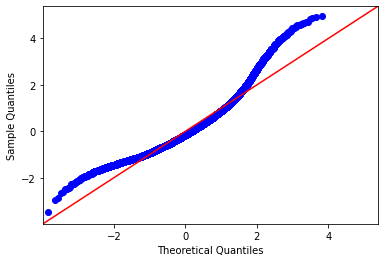

In [29]:
#Check Normality of Residuals
MLR_residuals= MLR_model.resid 
fig=sm.graphics.qqplot(MLR_residuals, dist=stats.norm, line='45', fit=True)
fig.show()

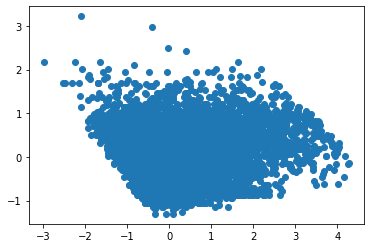

In [26]:
#Check Homoscedasticity of Residuals
plt.scatter(MLR_residuals, y_hat_MLR_train);

# Conclusion

regression perfromance
interpretation
recommendations

# Next Steps